In [20]:
from pathlib import Path
from protosc.io import read_image
import itertools
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix, csr_matrix

stim_data_dir = Path("..", "data", "Nimstim faces")
grayscale = True

open_files = stim_data_dir.glob("*_O.bmp")
closed_files = stim_data_dir.glob("*_C.bmp")

#     img = open_files[0]
data_file = list(itertools.islice(open_files, 1))[0]
img = read_image(data_file)[200:402, 200:402]


(202, 202)


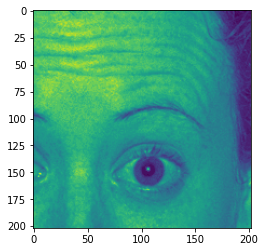

In [36]:
print(img.shape)
plt.imshow(img-np.mean(img))
plt.show()

In [27]:
fft_map = np.fft.fftshift(np.fft.fft2(img-np.mean(img)))
shifted_fft = np.absolute(fft_map)

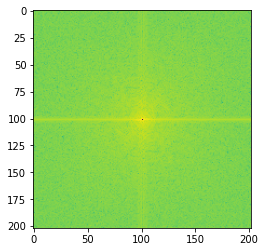

5372358.999999999
246173.8994138935


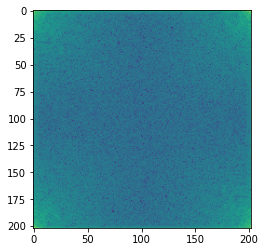

In [28]:
plt.imshow(np.log(shifted_fft))
plt.show()
plt.imshow(np.log(np.absolute(np.fft.fft2(img))))

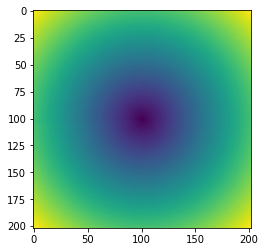

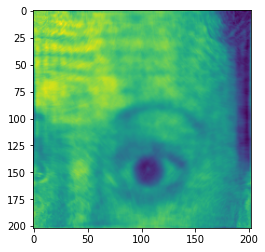

In [39]:
def transform_matrix(shape, n_angular=80, n_spatial=70, inverse=True):
    size = shape[0]*shape[1]
    X, Y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    middle = np.array([shape[0]//2, shape[1]//2])
    X -= middle[0]
    Y -= middle[1]

    radius = np.sqrt(X**2 + Y**2)
    angle = np.arctan2(Y, X)

    d_angle = 2*np.pi/n_angular
    d_radius = np.max(middle)/n_spatial
    angle_id = ((angle/d_angle + 0.5*(n_angular+1))%n_angular).astype(int)
    radius_id = (radius/d_radius).astype(int)
    all_id = angle_id+radius_id*n_angular
    plt.imshow(all_id)
    plt.show()

    indptr = np.arange(size+1)
    indices = all_id.reshape(-1)
    data = np.ones(size, dtype=int)
    trans_matrix = csc_matrix((data, indices, indptr), shape=(all_id.max()+1, size))

    if not inverse:
        return trans_matrix

    idx, temp_counts = np.unique(all_id, return_counts=True)
    counts = np.zeros(all_id.max()+1)
    counts[idx] = temp_counts
    indptr = np.arange(size+1)
    indices = all_id.reshape(-1)
    data = 1/counts[all_id.reshape(-1)]
    
    inv_trans_matrix = csr_matrix((data, indices, indptr), shape=(size, all_id.max()+1))
    return trans_matrix, inv_trans_matrix

trans, trans_inv = transform_matrix(fft_map.shape)
trans_data = trans.dot(fft_map.reshape(-1, 1))
reverse = trans_inv.dot(trans_data).reshape(fft_map.shape)
plt.imshow(np.real(np.fft.ifft2(np.fft.ifftshift(reverse))))
plt.show()
    